In [23]:
pip install ultralytics

Note: you may need to restart the kernel to use updated packages.


In [24]:
import cv2
from ultralytics import YOLO
#import numpy as np
import matplotlib.pyplot as plt


In [25]:
model = YOLO("best.pt")

In [26]:
# Path to your test image (change this to your own image path)
image_path = "test.png"

# Run detection
results = model(image_path, conf=0.5)  # confidence threshold 50%

# results[0] contains detections for the first (and only) image
results[0].show()   # OpenCV popup (if supported)


image 1/1 d:\GitHub\dspCPE4A2526\dspPython\Activity#9\test.png: 480x640 1 plates, 185.6ms
Speed: 2.3ms preprocess, 185.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


In [27]:
# Path to your image
image_path = "test.png"

# Run detection
results = model(image_path, conf=0.25)

# Get detection results for first (and only) image
boxes = results[0].boxes
names = model.names  # class names (COCO dataset: 'person' is class 0)

# Filter only "person" detections
person_boxes = []
for box in boxes:
    cls = int(box.cls[0])
    if names[cls] == "person":
        person_boxes.append(box)

print(f"Detected {len(person_boxes)} person(s).")



image 1/1 d:\GitHub\dspCPE4A2526\dspPython\Activity#9\test.png: 480x640 1 plates, 184.5ms
Speed: 1.7ms preprocess, 184.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)
Detected 0 person(s).


In [ ]:
img = cv2.imread(image_path)

# Draw only person detections
for box in boxes:
    cls = int(box.cls[0])
    if names[cls] == "person":
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        conf = float(box.conf[0])
        label = f"Person {conf:.2f}"

        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(img, label, (int(x1), int(y1) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

# Show in OpenCV window
cv2.imshow("Person Detection", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [29]:
pip install  pytesseract

Note: you may need to restart the kernel to use updated packages.



image 1/1 d:\GitHub\dspCPE4A2526\dspPython\Activity#9\test1.jpg: 640x480 1 plates, 199.2ms
Speed: 2.1ms preprocess, 199.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


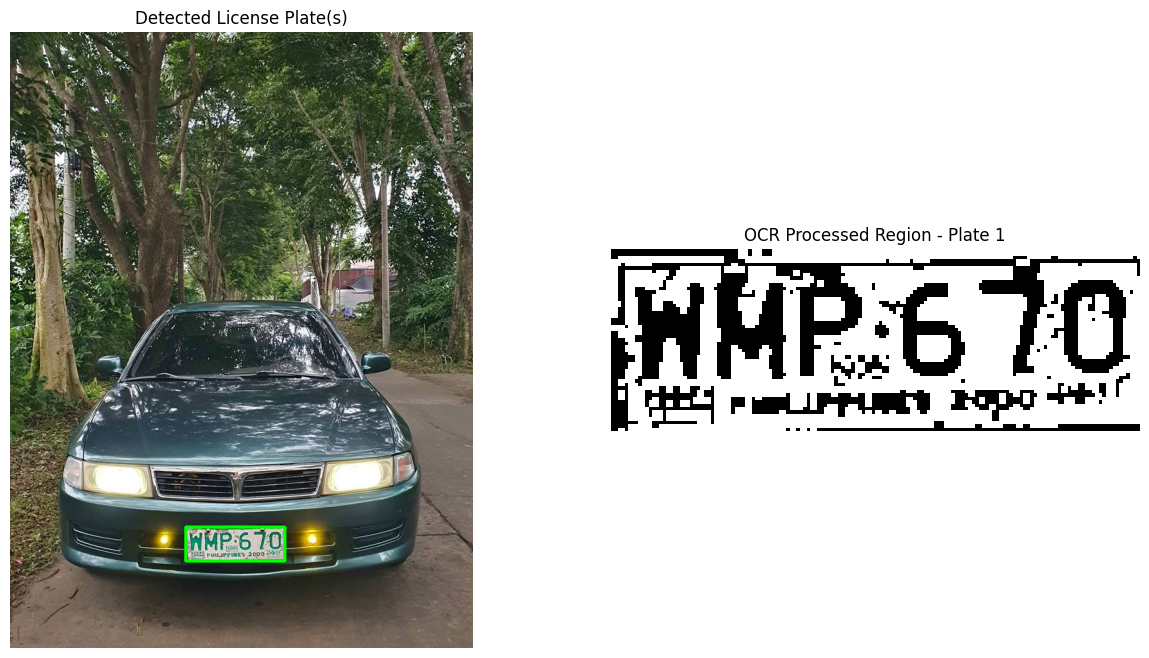

Extracted Text:
WMP670


In [64]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
import pytesseract
import re
import numpy as np

def extract_plate_details(image_path, model_path="best.pt", conf_thresh=0.5):
    model = YOLO(model_path)
    results = model(image_path, conf=conf_thresh)
    img = cv2.imread(image_path)
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))
    img_with_boxes = img.copy()
    plate_texts = []
    if hasattr(results[0], "boxes") and results[0].boxes.xyxy.shape[0] > 0:
        for i, box in enumerate(results[0].boxes.xyxy):
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), (0, 255, 0), 3)
            plate_img = img[y1:y2, x1:x2]

            gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
            _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
            cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

            custom_config = r'-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 --psm 7 -l eng'
            ocr_raw = pytesseract.image_to_string(cleaned, config=custom_config)

            # Preserve spaces between alphanumeric groups
            filtered_text = re.sub(r'[^A-Za-z0-9 ]', '', ocr_raw.strip())
            # Remove multiple leading/trailing spaces, but preserve inner ones
            filtered_text = re.sub(r' +', ' ', filtered_text).strip()
            plate_texts.append(filtered_text)
            
            axs[1].imshow(cleaned, cmap='gray')
            axs[1].set_title(f"OCR Processed Region - Plate {i+1}")
            axs[1].axis('off')
    else:
        axs[1].imshow(np.zeros((100, 250), dtype='uint8'), cmap='gray')
        axs[1].set_title("No Plate Detected")
        axs[1].axis('off')
    
    axs[0].imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Detected License Plate(s)")
    axs[0].axis("off")
    plt.show()
    
    return plate_texts

# Example usage:
plate_details = extract_plate_details("test1.jpg", "best.pt", 0.5)
print("Extracted Text:")
for detail in plate_details:
    print(detail)
